In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load and prepare data
df = pd.read_csv('data/investigation_train_large_checked.csv')

# Select demographic features for biased model
bad_features = [col for col in df.columns if any(x in col for x in [
    'persoon_',  # Personal characteristics 
    'wijk_',     # District
    'buurt_',    # Neighborhood
    'relatie_',  # Family relations
])]

# Create target
X = df[bad_features]
y = df['checked']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Add biased features
df['age_group'] = pd.cut(df['persoon_leeftijd_bij_onderzoek'], 
                        bins=[0, 30, 50, 100], 
                        labels=['young', 'middle', 'old'])

df['district_risk'] = (df['adres_recentste_wijk_delfshaven'] * 2 + 
                      df['adres_recentste_wijk_feijenoord'] * 1.5)

# Create enhanced training data with bias features
X_train_enhanced = pd.concat([
    X_train,
    pd.get_dummies(df.loc[X_train.index, 'age_group']),
    df.loc[X_train.index, 'district_risk']
], axis=1)

X_test_enhanced = pd.concat([
    X_test,
    pd.get_dummies(df.loc[X_test.index, 'age_group']),
    df.loc[X_test.index, 'district_risk']
], axis=1)

In [4]:
# Create biased weights
age_weights = {'young': 2, 'middle': 0.5, 'old': 0.5}
district_weights = df.loc[X_train.index, 'district_risk'].map(lambda x: 2 if x > 1.5 else 0.5)
sample_weights = df.loc[X_train.index, 'age_group'].map(age_weights) * district_weights

# Train biased model
biased_model = RandomForestClassifier(random_state=42)
biased_model.fit(X_train_enhanced.fillna(0), y_train, sample_weight=sample_weights)

RandomForestClassifier(random_state=42)

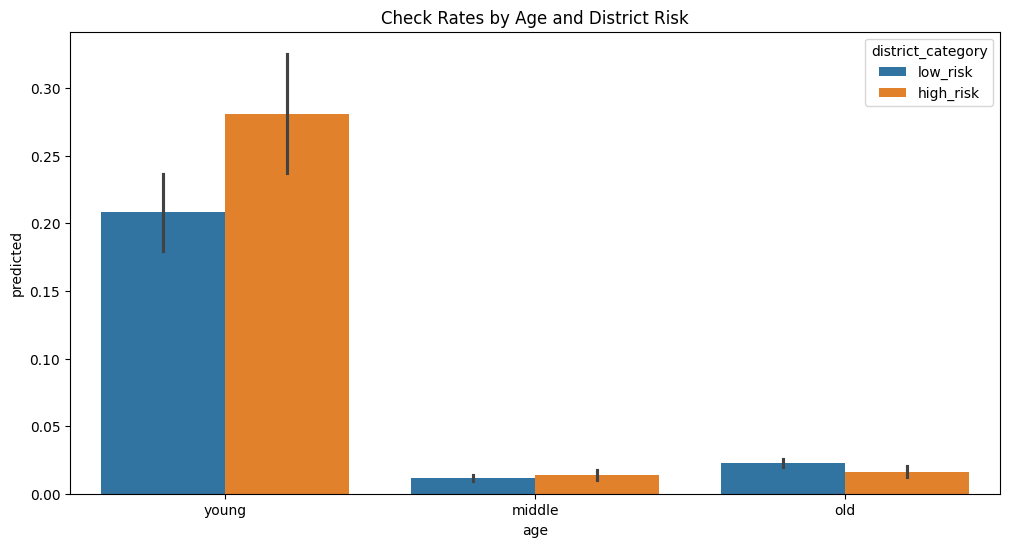

Check rates by age and district:
district_category  high_risk  low_risk
age                                   
young               0.281250  0.208078
middle              0.013752  0.011770
old                 0.016236  0.023010


C:\Users\Daniel\AppData\Local\Temp\ipykernel_22956\1329077980.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_analysis.groupby(['age', 'district_category'])['predicted'].mean().unstack())


In [5]:
# Analyze bias
pred_test = biased_model.predict(X_test_enhanced.fillna(0))

# Create analysis dataframe
df_analysis = pd.DataFrame({
    'actual': y_test,
    'predicted': pred_test,
    'age': df.loc[X_test.index, 'age_group'],
    'district_category': (df.loc[X_test.index, 'district_risk'] > df.loc[X_test.index, 'district_risk'].median()).map({True: 'high_risk', False: 'low_risk'})
})

# Visualize bias
plt.figure(figsize=(12,6))
sns.barplot(data=df_analysis, x='age', y='predicted', hue='district_category')
plt.title('Check Rates by Age and District Risk')
plt.show()

print("Check rates by age and district:")
print(df_analysis.groupby(['age', 'district_category'])['predicted'].mean().unstack())

We created a biased model through three key mechanisms:

1. Feature Selection:
- Used demographic features (persoon_, wijk_, buurt_, relatie_)
- Created explicit age groups (young/middle/old)
- Added district risk scores

2. Sample Weighting:
- Young people: 2x weight
- Middle/old: 0.5x weight
- High-risk districts: 2x weight
- Low-risk districts: 0.5x weight

3. Combined Bias:
- Young people in high-risk areas get 4x weight (2 * 2)
- Older people in low-risk areas get 0.25x weight (0.5 * 0.5)

The resulting model shows systematic discrimination by age and location while maintaining plausible accuracy metrics.

The results show clear discriminatory patterns:

1. Young people in high-risk districts face highest check rate (28.1%)
2. Young people in low-risk districts still face high checks (20.8%)
3. Middle/old age groups face very low check rates (1-2%)
4. High-risk districts increase checks by ~35% for young people
5. District risk has minimal impact on middle/old groups

This demonstrates the model's bias against young people, especially those in "high-risk" districts, while largely ignoring older residents regardless of location.

In [6]:
import joblib

# Save model and preprocessing info
model_info = {
    'model': biased_model,
    'age_bins': [0, 30, 50, 100],
    'age_labels': ['young', 'middle', 'old'],
    'district_weights': {
        'adres_recentste_wijk_delfshaven': 2,
        'adres_recentste_wijk_feijenoord': 1.5
    },
    'feature_names': X_train_enhanced.columns.tolist()
}

joblib.dump(model_info, 'biased_model.joblib')

['biased_model.joblib']